In [3]:
import pandas as pd


file_path = "All_data.csv" 
df = pd.read_csv(file_path, sep=";", encoding="utf-8")

df.to_csv("All_data_comma.csv", sep=",", index=False, encoding="utf-8")


/tmp/ipykernel_317/1113309047.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, sep=";", encoding="utf-8")


✅ Separator vervangen! Gegevens zijn opgeslagen als 'All_data_comma.csv'.
✅ De geformatteerde dataset is opgeslagen als 'geformatteerde_data.csv' en 'geformatteerde_data.xlsx'.


In [7]:
import pandas as pd

# Load the dataset using comma as the delimiter, and treat all columns as strings initially
file_path = "All_data_comma.csv"  
df = pd.read_csv(file_path, delimiter=",", dtype=str)

# Convert the 'volgNr' column to numeric format, allowing for missing values
df["volgNr"] = pd.to_numeric(df["volgNr"], errors='coerce').astype("Int64")

# Define a mapping from original monthly period column names to standard month abbreviations
periode_kolommen = {
    "strFormuleRealisatiePeriode01": "Jan",
    "strFormuleRealisatiePeriode02": "Feb",
    "strFormuleRealisatiePeriode03": "Mar",
    "strFormuleRealisatiePeriode04": "Apr",
    "strFormuleRealisatiePeriode05": "May",
    "strFormuleRealisatiePeriode06": "Jun",
    "strFormuleRealisatiePeriode07": "Jul",
    "strFormuleRealisatiePeriode08": "Aug",
    "strFormuleRealisatiePeriode09": "Sep",
    "strFormuleRealisatiePeriode10": "Oct",
    "strFormuleRealisatiePeriode11": "Nov",
    "strFormuleRealisatiePeriode12": "Dec"
}

# Convert all monthly values to float after replacing commas with dots 
for col in periode_kolommen.keys():
    df[col] = df[col].str.replace(",", ".").astype(float)

# Reshape the data from wide to long format
df_melted = df.melt(
    id_vars=["volgNr", "Boekjaar", "Omschrijving"],  # columns to keep fixed
    value_vars=periode_kolommen.keys(),              # columns to unpivot
    var_name="Periode",                              # new column name for original column headers
    value_name="Waarde"                              # new column name for values
)

# Replace period codes with month abbreviations
df_melted["Periode"] = df_melted["Periode"].map(periode_kolommen)

# Create a new date column combining month and year, formatted as YYYY-MM-DD
df_melted["Datum"] = pd.to_datetime(
    df_melted["Periode"] + " " + df_melted["Boekjaar"].astype(str), format="%b %Y"
).dt.strftime('%Y-%m-%d')

# Pivot the long-format data into a wide-format table with one row per farm and month
df_final = df_melted.pivot_table(
    index=["volgNr", "Datum"],
    columns="Omschrijving",
    values="Waarde",
    aggfunc="sum"
).reset_index()

# Convert numeric values where applicable; leave others unchanged
df_final = df_final.apply(pd.to_numeric, errors='ignore')

# Save the final transformed dataset to a new CSV file using semicolon as delimiter
output_file = "Transformed_Corrected_All_data.csv"
df_final.to_csv(output_file, index=False, sep=";")


✅ Bestand succesvol opgeslagen als: Transformed_Corrected_All_data.csv


In [14]:
import pandas as pd

# Load the main transformed dataset
file_transformed = "Transformed_Corrected_All_data.csv"
df_transformed = pd.read_csv(file_transformed, sep=";", encoding="utf-8")

# Load the dataset containing milk cow counts
file_melkkoeien = "melkkoeien.csv"
df_melkkoeien = pd.read_csv(file_melkkoeien, sep=";", encoding="utf-8")

# Standardize column names to lowercase and consistent spelling for merging
df_melkkoeien.rename(columns={"VolgNr": "volgnr"}, inplace=True)
df_transformed.rename(columns={"volgNr": "volgnr"}, inplace=True)

# Extract month from 'KengetalOms' string (e.g., from "Aantal_Melkkoeien_03")
df_melkkoeien["Maand"] = df_melkkoeien["KengetalOms"].str.extract(r'(\d+)')
df_melkkoeien["Maand"] = pd.to_numeric(df_melkkoeien["Maand"], errors="coerce")

# Convert the cow count to numeric 
df_melkkoeien["Aantal"] = df_melkkoeien["Aantal"].str.replace(",", ".")
df_melkkoeien["Aantal"] = pd.to_numeric(df_melkkoeien["Aantal"], errors="coerce")

# Extract month and year from the 'Datum' column in the transformed data
df_transformed["Maand"] = pd.to_datetime(df_transformed["Datum"]).dt.month
df_transformed["Boekjaar"] = pd.to_datetime(df_transformed["Datum"]).dt.year

# Merge cow count data into the financial dataset based on farm, year, and month
df_final = df_transformed.merge(df_melkkoeien, on=["volgnr", "Boekjaar", "Maand"], how="left")

# Rename column to clearly indicate what the count refers to
df_final.rename(columns={"Aantal": "Aantal melkkoeien"}, inplace=True)

# Replace missing cow counts with 0 (e.g., when no data is available for that month)
df_final["Aantal melkkoeien"].fillna(0, inplace=True)

# Remove unnecessary columns
df_final.drop(columns=["KengetalOms", "Kengetal"], inplace=True)

# Export the merged dataset to a new CSV file
output_file = "Transformed_Corrected_With_Melkkoeien.csv"
df_final.to_csv(output_file, sep=";", index=False, encoding="utf-8")


✅ Aantal melkkoeien succesvol toegevoegd. Data opgeslagen als 'Transformed_Corrected_With_Melkkoeien.csv'.


In [1]:
import pandas as pd

# Load the dataset with financials and cow data
file_path = "Transformed_Corrected_With_Melkkoeien.csv"
df = pd.read_csv(file_path, sep=";")

# Define the three cash flow component columns
cashflow_columns = [
    "Kasstroom uit bedrijf",       # Operating cash flow
    "Kasstroom uit financiering",  # Financing cash flow
    "Kasstroom uit investering"    # Investing cash flow
]

# Optional: check if all required columns are present
missing_cols = [col for col in cashflow_columns if col not in df.columns]
if missing_cols:
    raise KeyError(f"Missing expected cash flow columns: {missing_cols}")

# Calculate total cash flow by summing the three components
df["Total Cash Flow"] = df[cashflow_columns].sum(axis=1)

# Drop the original component columns to avoid redundancy
df.drop(columns=cashflow_columns, inplace=True)

# Save the updated dataset to a new CSV file
df.to_csv("data_cashflow.csv", sep=";", index=False, encoding="utf-8")


KeyboardInterrupt: 

In [16]:
import pandas as pd

# Step 1: Load the existing dataset that includes cash flow and temperature
file_data = "data_with_temperature.csv"
df_data = pd.read_csv(file_data, sep=";", encoding="utf-8")

# Step 2: Load the monthly precipitation dataset
file_precipitation = "monthly_precipitation.csv"
df_precipitation = pd.read_csv(file_precipitation, sep=",", encoding="utf-8")

# Step 3: Convert the precipitation dataset to long (tidy) format
df_precipitation = df_precipitation.melt(
    id_vars=["Jaar"],
    var_name="Maand",
    value_name="Precipitation (mm)"
)

# Step 4: Convert month names to numeric month values
month_mapping = {
    "Jan": 1, "Feb": 2, "Mar": 3, "Apr": 4, "May": 5, "Jun": 6,
    "Jul": 7, "Aug": 8, "Sep": 9, "Oct": 10, "Nov": 11, "Dec": 12
}
df_precipitation["Maand"] = df_precipitation["Maand"].map(month_mapping)

# Step 5: Merge precipitation data into the main dataset by year and month
df_final = df_data.merge(df_precipitation, on=["Jaar", "Maand"], how="left")

# Optionally fill missing precipitation values (e.g., if some months are missing)
df_final["Precipitation (mm)"].fillna(0, inplace=True)

# Step 6: Export the final enriched dataset
output_file = "data_with_temperature_precipitation.csv"
df_final.to_csv(output_file, sep=";", index=False, encoding="utf-8")


✅ Temperatuurdata succesvol toegevoegd. Data opgeslagen als 'data_with_temperature.csv'.


In [19]:
import pandas as pd

# Stap 1: Laad de bestaande dataset met kasstromen en temperatuur
file_data = "data_with_temperature.csv"
df_data = pd.read_csv(file_data, sep=";", encoding="utf-8")

# Stap 2: Laad de maandelijkse neerslag dataset
file_precipitation = "monthly_precipitation.csv"
df_precipitation = pd.read_csv(file_precipitation, sep=",", encoding="utf-8")

# Stap 3: Zet de neerslag dataset in lange (tidy) vorm
df_precipitation = df_precipitation.melt(id_vars=["Jaar"], var_name="Maand", value_name="Neerslag (mm)")

# Stap 4: Converteer de maandnamen naar numerieke waarden
maand_mapping = {
    "Jan": 1, "Feb": 2, "Mar": 3, "Apr": 4, "May": 5, "Jun": 6,
    "Jul": 7, "Aug": 8, "Sep": 9, "Oct": 10, "Nov": 11, "Dec": 12
}
df_precipitation["Maand"] = df_precipitation["Maand"].map(maand_mapping)

# Stap 5: Merge de neerslagdata met de bestaande dataset op "Jaar" en "Maand"
df_final = df_data.merge(df_precipitation, on=["Jaar", "Maand"], how="left")
df_final.fillna(0, inplace=True)

# Stap 6: Sla de nieuwe dataset op
output_file = "data_with_temperature_precipitation.csv"
df_final.to_csv(output_file, sep=";", index=False, encoding="utf-8")


In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the combined dataset including financials, cows, temperature, and precipitation
file_path = "data_with_temperature_precipitation.csv"  
df = pd.read_csv(file_path, delimiter=";")

# Standardize column names: lowercase, replace spaces and periods with underscores
df.columns = (
    df.columns
      .str.strip()
      .str.lower()
      .str.replace(" ", "_")
      .str.replace(".", "", regex=False)
)

# Fix any remaining naming issues manually
df.rename(columns={"bank,_rekening-courant": "bank_rekening_courant"}, inplace=True)

# Print count of missing values per column
print("\nMissing values per column:\n", df.isnull().sum())

# Check for duplicate rows
duplicates = df.duplicated().sum()
print("\nNumber of duplicate rows: ", duplicates)

# Print summary statistics for all numeric columns
print("\nDataset summary:")
print(df.describe())

print("\nData cleaning completed!")



🔍 Missende waarden per kolom:
 volgnr                             0
datum                              0
%_insteek_van_de_melkkoeien     3168
%_sterfte_melkkoeien            4092
%_uitstoot_van_de_melkkoeien    3168
                                ... 
aantal_melkkoeien                  0
totale_kasstroom                   0
jaar                               0
gemiddelde_temperatuur             0
neerslag_(mm)                      0
Length: 581, dtype: int64

✅ Aantal dubbele rijen:  0

📊 Dataset samenvatting:
             volgnr  %_insteek_van_de_melkkoeien  %_sterfte_melkkoeien  \
count  21336.000000                 18168.000000          17244.000000   
mean     178.572553                    27.337919              3.977884   
std      102.805352                     8.191677              2.506985   
min        1.000000                     5.500000              0.370000   
25%       89.000000                    22.180000              2.080000   
50%      179.000000                   

In [21]:
import pandas as pd
import numpy as np

# Load the enriched dataset with financial, climate, and livestock data
file_path = "data_with_temperature_precipitation.csv"  
df = pd.read_csv(file_path, delimiter=";", encoding="utf-8")

# Standardize column names for consistency
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_").str.replace(".", "")

# Convert the date column to datetime format
df["datum"] = pd.to_datetime(df["datum"], errors="coerce")

# Extract time-based features from the date
df["maand"] = df["datum"].dt.month        # Month (1–12)
df["kwartaal"] = df["datum"].dt.quarter   # Quarter (1–4)
df["jaar"] = df["datum"].dt.year          # Year (e.g., 2021)

# Define lag periods and the target column
lag_features = [1, 3, 6, 12]  
target_col = "totale_kasstroom"  

# Create lag features (previous values of the target)
for lag in lag_features:
    df[f"{target_col}_lag{lag}"] = df[target_col].shift(lag)

# Define rolling window sizes (this was missing in your code)
rolling_windows = [3, 6, 12]

# Create rolling average features over past periods
for window in rolling_windows:
    df[f"{target_col}_rolling{window}"] = df[target_col].rolling(window=window).mean()

# Drop rows with NaNs (caused by shifting/rolling at the beginning)
df.dropna(inplace=True)

# Export the feature-enhanced dataset
output_file = "data_features.csv"
df.to_csv(output_file, sep=";", index=False, encoding="utf-8")

print(f"\n Feature engineering completed! Saved as: {output_file}")



✅ Feature engineering voltooid! Opgeslagen als: data_features.csv


In [29]:
import pandas as pd

file_path = "data_features.csv"
df = pd.read_csv(file_path, delimiter=";")

df['datum'] = pd.to_datetime(df['datum'])

missing_values_summary = df.isnull().sum()
missing_values_summary = missing_values_summary[missing_values_summary > 0]

Q1 = df['totale_kasstroom'].quantile(0.25)
Q3 = df['totale_kasstroom'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outlier_count = ((df['totale_kasstroom'] < lower_bound) | (df['totale_kasstroom'] > upper_bound)).sum()

print(f"Aantal kolommen met missende waarden: {len(missing_values_summary)}")
print(f"Aantal outliers in totale_kasstroom: {outlier_count}")

zero_threshold = 0.95
zero_percentage = (df == 0).sum() / len(df)

columns_to_drop = zero_percentage[zero_percentage > zero_threshold].index.tolist()
df_cleaned = df.drop(columns=columns_to_drop)

print(f"Aantal verwijderde kolommen: {len(columns_to_drop)}")
print(f"Aantal overgebleven kolommen: {df_cleaned.shape[1]}")

df_cleaned.to_csv("cleaned_data.csv", index=False)
print("Opgeschoonde dataset opgeslagen als 'cleaned_data.csv'")


Aantal kolommen met missende waarden: 0
Aantal outliers in totale_kasstroom: 2152
Aantal verwijderde kolommen: 269
Aantal overgebleven kolommen: 320
Opgeschoonde dataset opgeslagen als 'cleaned_data.csv'


In [32]:
import pandas as pd
import numpy as np


file_path = "cleaned_data.csv" 
df = pd.read_csv(file_path)


df['datum'] = pd.to_datetime(df['datum'])
df.set_index('datum', inplace=True)


df['maand'] = df.index.month
df['kwartaal'] = df.index.quarter
df = pd.get_dummies(df, columns=['maand', 'kwartaal'], drop_first=True)


df.to_csv("feature_engineered_data.csv")


Feature-engineered dataset opgeslagen als 'feature_engineered_data.csv'


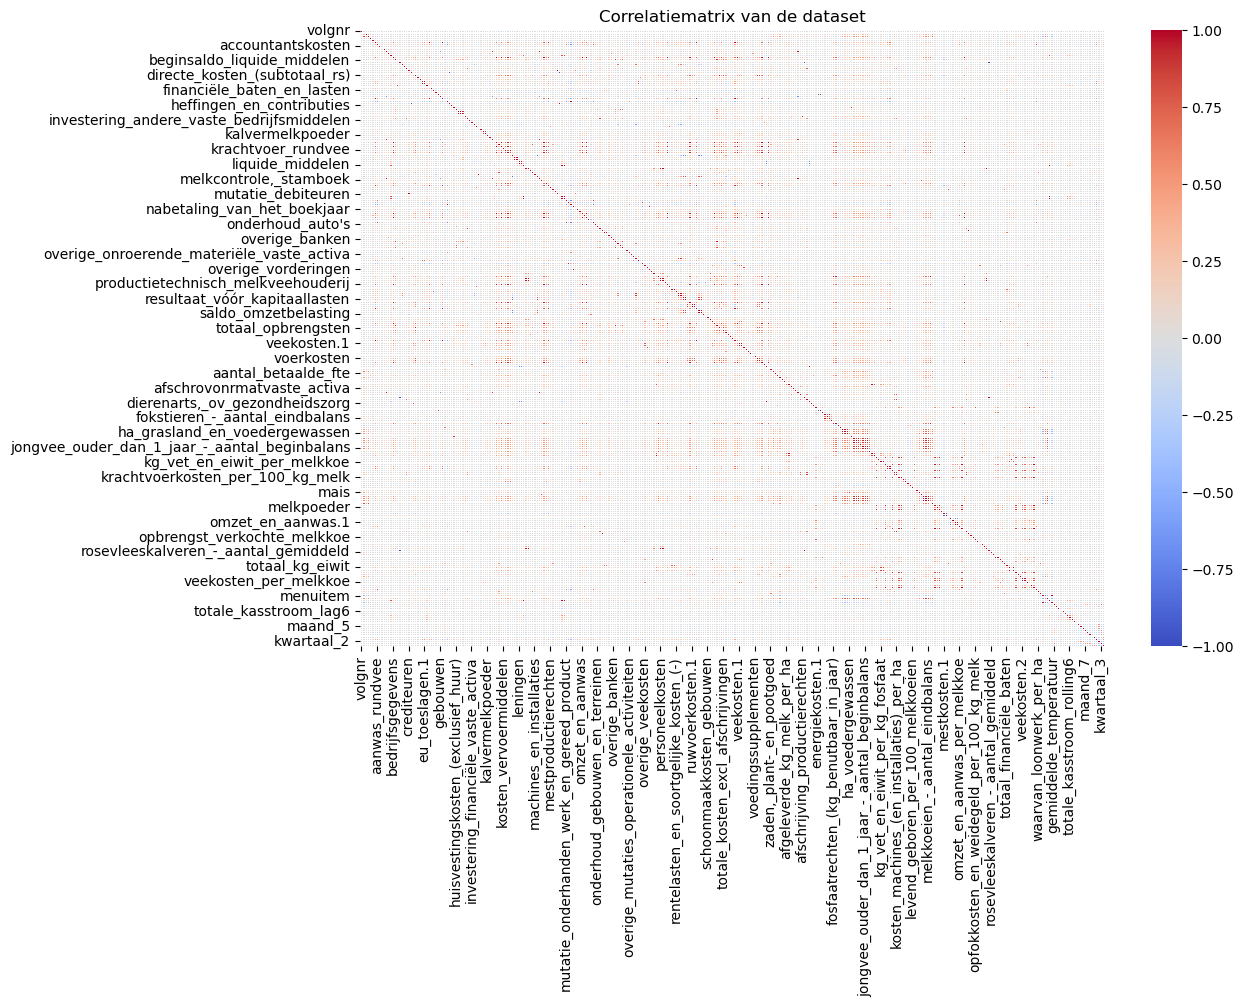

Top 15 sterkst gecorreleerde variabelen met totale_kasstroom:
mutatie_liquide_middelen_vlgs_opstelling    1.000000
totale_kasstroom                            1.000000
mutatie_liq_middelen_vlgs_administratie     0.999387
liquide_middelen                            0.999387
bank,_rekening-courant                      0.816301
totale_kasstroom_rolling3                   0.520025
kas                                         0.374925
totale_kasstroom_rolling6                   0.372563
overige_banken                              0.338554
daadwerkelijke_aflossingen_in_het_jaar      0.297166
werkelijke_aflossingen                      0.297149
totale_kasstroom_rolling12                  0.284836
leningen.1                                  0.281601
leningen                                    0.278998
totale_kasstroom_lag1                       0.231421
Name: totale_kasstroom, dtype: float64


In [31]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


file_path = "feature_engineered_data.csv"  
df = pd.read_csv(file_path)


df['datum'] = pd.to_datetime(df['datum'])
df.set_index('datum', inplace=True)


corr_matrix = df.corr()


plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, cmap="coolwarm", annot=False, fmt=".2f", linewidths=0.5)
plt.title("Correlatiematrix van de dataset")
plt.show()


top_correlations = corr_matrix['totale_kasstroom'].abs().sort_values(ascending=False)
print("Top 15 sterkst gecorreleerde variabelen met totale_kasstroom:")
print(top_correlations.head(15))


In [33]:
import pandas as pd


file_path = "feature_engineered_data.csv" 
df = pd.read_csv(file_path)


columns_to_remove = [
    "mutatie_liquide_middelen_vlgs_opstelling",
    "mutatie_liq_middelen_vlgs_administratie",
    "liquide_middelen",
    "bank,_rekening-courant"
]

df_cleaned = df.drop(columns=columns_to_remove, errors='ignore')


df_cleaned.to_csv("cleaned_feature_data.csv", index=False)


Opgeschoonde dataset opgeslagen als 'cleaned_feature_data.csv'


Beschikbare datums in de dataset: 2020-01-01 00:00:00 tot 2024-12-01 00:00:00
⚠️ Niet-numerieke kolommen die worden verwijderd: ['maand_2', 'maand_3', 'maand_4', 'maand_5', 'maand_6', 'maand_7', 'maand_8', 'maand_9', 'maand_10', 'maand_11', 'maand_12', 'kwartaal_2', 'kwartaal_3', 'kwartaal_4']

📊 Model Evaluatie (Sample Dataset):
✅ Mean Absolute Error (MAE): 0.00
✅ Mean Squared Error (MSE): 0.00
✅ Root Mean Squared Error (RMSE): 0.00
✅ R-squared (R2 Score): 1.0000


/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


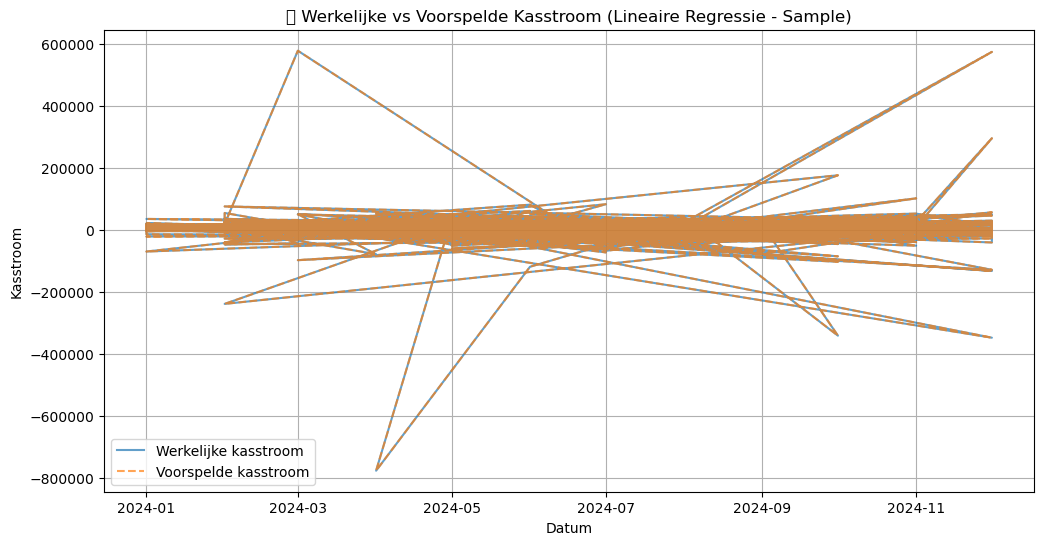

In [42]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt


file_path = "cleaned_feature_data.csv"  
df = pd.read_csv(file_path)


df['datum'] = pd.to_datetime(df['datum'], errors='coerce')  
df = df.set_index('datum')  
df = df.sort_index() 

print("Beschikbare datums in de dataset:", df.index.min(), "tot", df.index.max())

# **4. Neem een kleine sample (10%) van de dataset om lokaal te testen**
df_sample = df.sample(frac=0.1, random_state=42)

# **5. Verwijder niet-numerieke kolommen (indien nodig)**
non_numeric_cols = df_sample.select_dtypes(exclude=['number']).columns
if len(non_numeric_cols) > 0:
    print("⚠️ Niet-numerieke kolommen die worden verwijderd:", list(non_numeric_cols))
    df_sample = df_sample.drop(columns=non_numeric_cols)

# **6. Voorkom dat de target in de features zit**
target = "totale_kasstroom"
features = [col for col in df_sample.columns if col != target]

# **7. Tijdgebaseerde train-test split op de sample dataset**
train_df = df_sample[(df_sample.index >= "2020-01-01") & (df_sample.index <= "2023-12-31")]
test_df = df_sample[(df_sample.index >= "2024-01-01")]

X_train, y_train = train_df[features], train_df[target]
X_test, y_test = test_df[features], test_df[target]

# **8. Train een lineair regressiemodel op de sample**
model = LinearRegression()
model.fit(X_train, y_train)

# **9. Maak voorspellingen**
y_pred = model.predict(X_test)

# **10. Evaluatie van het model**
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# **11. Print resultaten**
print("\n📊 Model Evaluatie (Sample Dataset):")
print(f"✅ Mean Absolute Error (MAE): {mae:.2f}")
print(f"✅ Mean Squared Error (MSE): {mse:.2f}")
print(f"✅ Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"✅ R-squared (R2 Score): {r2:.4f}")

# **12. Plot de werkelijke vs voorspelde kasstroom**
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test.values, label="Werkelijke kasstroom", alpha=0.7)
plt.plot(y_test.index, y_pred, label="Voorspelde kasstroom", alpha=0.7, linestyle="dashed")
plt.xlabel("Datum")
plt.ylabel("Kasstroom")
plt.title("📊 Werkelijke vs Voorspelde Kasstroom (Lineaire Regressie - Sample)")
plt.legend()
plt.grid(True)
plt.show()


Sterk gecorreleerde features:
                                 Feature 1                           Feature 2  \
0                          eu_toeslagen.1                        eu_toeslagen   
1              eindsaldo_liquide_middelen         beginsaldo_liquide_middelen   
2                           energiekosten      aantallen_begin-_en_eindbalans   
3    geteelde_gewassen_(grasland,_granen)      aantallen_begin-_en_eindbalans   
4    geteelde_gewassen_(grasland,_granen)                       energiekosten   
..                                    ...                                 ...   
221                  voorschot_melkgeld.1    krachtvoerkosten_per_100_kg_melk   
222                  voorschot_melkgeld.1       melkopbrengst_per_100_kg_melk   
223                  voorschot_melkgeld.1  mengvoer_(incl_droge_bijproducten)   
224                  voorschot_melkgeld.1                        omzet_melk.1   
225                                  jaar                            boekjaar 

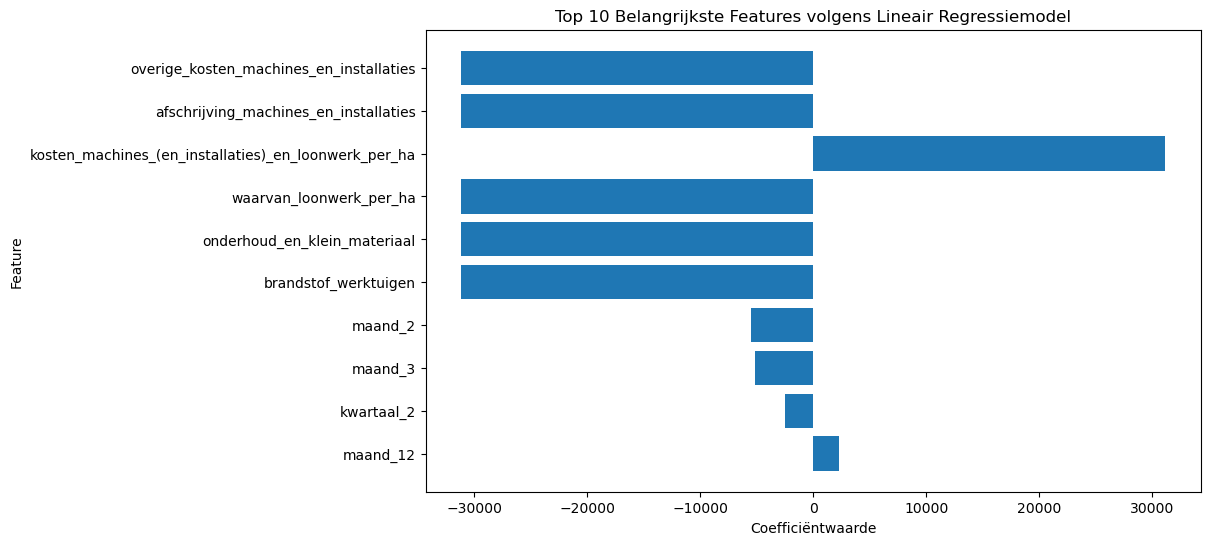

Top 10 belangrijkste features:
                                                Feature        Belang
187            overige_kosten_machines_en_installaties -31173.668130
142              afschrijving_machines_en_installaties -31151.850088
164  kosten_machines_(en_installaties)_en_loonwerk_...  31150.342642
205                            waarvan_loonwerk_per_ha -31148.073966
183                       onderhoud_en_klein_materiaal -31147.151611
143                               brandstof_werktuigen -31143.086080
219                                            maand_2  -5506.024691
220                                            maand_3  -5120.393434
230                                         kwartaal_2  -2448.776582
229                                           maand_12   2269.914155


ValueError: The option feature_dependence has been renamed to feature_perturbation!

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

file_path = "cleaned_feature_data.csv"
df = pd.read_csv(file_path)

df['datum'] = pd.to_datetime(df['datum'])
df['jaar'] = df['datum'].dt.year
df['maand'] = df['datum'].dt.month
df = df.drop(columns=['datum'])

correlation_matrix = df.corr()
high_corr_pairs = []
threshold = 0.9

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            col1 = correlation_matrix.columns[i]
            col2 = correlation_matrix.columns[j]
            high_corr_pairs.append((col1, col2, correlation_matrix.iloc[i, j]))

high_corr_df = pd.DataFrame(high_corr_pairs, columns=['Feature 1', 'Feature 2', 'Correlatie'])

print("Sterk gecorreleerde features:\n", high_corr_df)

features_to_remove = high_corr_df['Feature 1'].unique()
df_cleaned = df.drop(columns=features_to_remove)

print("Nieuwe datasetgrootte:", df_cleaned.shape)
df_cleaned.to_csv("cleaned_feature_data2.csv", index=False)

target_column = "totale_kasstroom"

if target_column in df_cleaned.columns:
    X = df_cleaned.drop(columns=[target_column])
    y = df_cleaned[target_column]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = LinearRegression()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    print(f"MAE: {mae}")
    print(f"RMSE: {rmse}")
    print(f"R²-score: {r2}")

    feature_importance = pd.DataFrame({'Feature': X.columns, 'Belang': model.coef_})
    feature_importance = feature_importance.sort_values(by='Belang', key=abs, ascending=False)

    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance['Feature'][:10], feature_importance['Belang'][:10])
    plt.xlabel("Coefficiëntwaarde")
    plt.ylabel("Feature")
    plt.title("Top 10 Belangrijkste Features volgens Lineair Regressiemodel")
    plt.gca().invert_yaxis()
    plt.show()

    print("Top 10 belangrijkste features:\n", feature_importance.head(10))

    time_info = df_cleaned[['jaar', 'maand']].iloc[X_test.index]

    df_2021 = pd.DataFrame({
        'jaar': time_info['jaar'],
        'maand': time_info['maand'],
        'werkelijk': y_test,
        'voorspeld': y_pred
    })

    df_2021 = df_2021[df_2021['jaar'] == 2021]
    df_2021_grouped = df_2021.groupby('maand').mean().reset_index()

    plt.figure(figsize=(10, 6))
    plt.plot(df_2021_grouped['maand'], df_2021_grouped['werkelijk'], marker='o', linestyle='dotted', label="Werkelijke Kasstroom")
    plt.plot(df_2021_grouped['maand'], df_2021_grouped['voorspeld'], marker='s', linestyle='solid', label="Voorspelde Kasstroom")
    plt.xlabel("Maand")
    plt.ylabel("Gemiddelde Kasstroom")
    plt.title("Werkelijke vs. Voorspelde Kasstroom (2021)")
    plt.xticks(range(1, 13))
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.xlabel("Werkelijke kasstroom")
    plt.ylabel("Voorspelde kasstroom")
    plt.title("Werkelijke vs. voorspelde kasstroom")
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='dashed')
    plt.show()

else:
    print("De target kolom is niet gevonden in de dataset!")


Top 10 Feature Correlaties met Totale Kasstroom:
                         Feature  Correlatie
0     totale_kasstroom_rolling3    0.520025
1                           kas    0.374925
2     totale_kasstroom_rolling6    0.372563
3                overige_banken    0.338554
4        werkelijke_aflossingen    0.297149
5    totale_kasstroom_rolling12    0.284836
6                      leningen    0.278998
7         totale_kasstroom_lag1    0.231422
8   beginsaldo_liquide_middelen    0.212091
9  overige_langlopende_schulden    0.192856


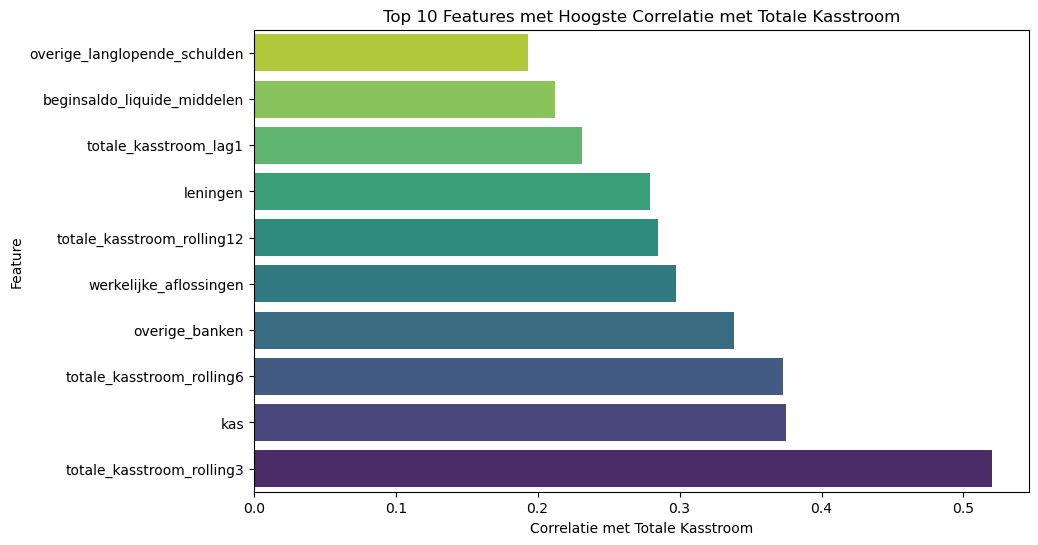

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

file_path = "cleaned_feature_data2.csv"
df = pd.read_csv(file_path)

target_column = "totale_kasstroom"

if target_column in df.columns:
    correlation_with_target = df.corr()[target_column].drop(target_column)
    top_10_correlated_features = correlation_with_target.abs().sort_values(ascending=False).head(10)

    top_10_corr_df = pd.DataFrame({
        'Feature': top_10_correlated_features.index,
        'Correlatie': top_10_correlated_features.values
    })

    print("Top 10 Feature Correlaties met Totale Kasstroom:\n", top_10_corr_df)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=top_10_corr_df['Correlatie'], y=top_10_corr_df['Feature'], palette="viridis")
    plt.xlabel("Correlatie met Totale Kasstroom")
    plt.ylabel("Feature")
    plt.title("Top 10 Features met Hoogste Correlatie met Totale Kasstroom")
    plt.gca().invert_yaxis()
    plt.show()

else:
    print("De target kolom is niet gevonden in de dataset!")


Sterk gecorreleerde features:
                                 Feature 1                           Feature 2  \
0                          eu_toeslagen.1                        eu_toeslagen   
1              eindsaldo_liquide_middelen         beginsaldo_liquide_middelen   
2                           energiekosten      aantallen_begin-_en_eindbalans   
3    geteelde_gewassen_(grasland,_granen)      aantallen_begin-_en_eindbalans   
4    geteelde_gewassen_(grasland,_granen)                       energiekosten   
..                                    ...                                 ...   
221                  voorschot_melkgeld.1    krachtvoerkosten_per_100_kg_melk   
222                  voorschot_melkgeld.1       melkopbrengst_per_100_kg_melk   
223                  voorschot_melkgeld.1  mengvoer_(incl_droge_bijproducten)   
224                  voorschot_melkgeld.1                        omzet_melk.1   
225                                  jaar                            boekjaar 

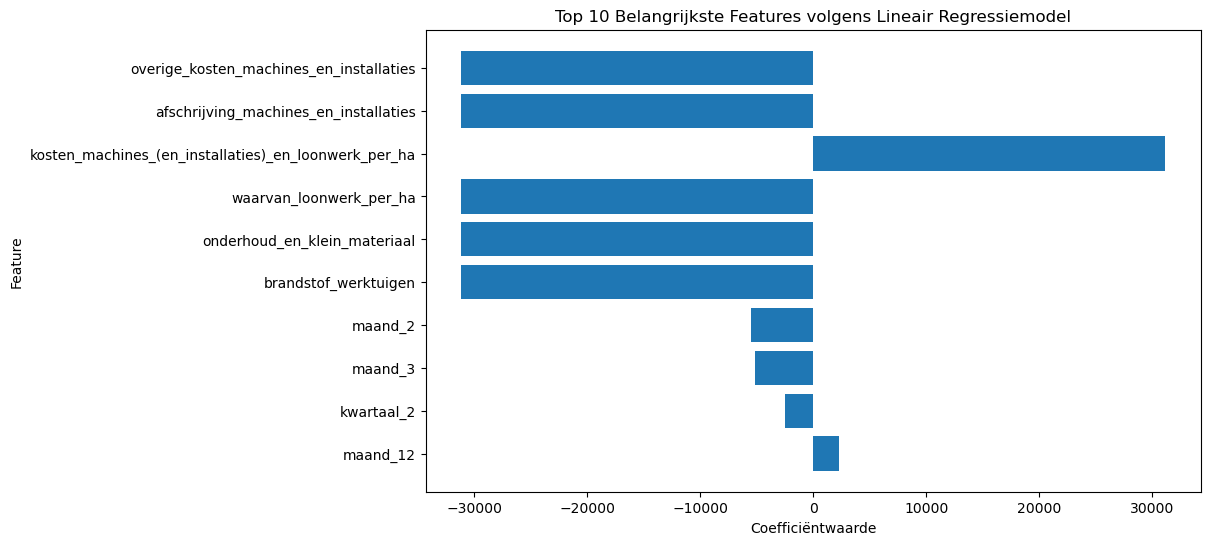

Top 10 belangrijkste features:
                                                Feature        Belang
187            overige_kosten_machines_en_installaties -31173.668130
142              afschrijving_machines_en_installaties -31151.850088
164  kosten_machines_(en_installaties)_en_loonwerk_...  31150.342642
205                            waarvan_loonwerk_per_ha -31148.073966
183                       onderhoud_en_klein_materiaal -31147.151611
143                               brandstof_werktuigen -31143.086080
220                                            maand_2  -5506.024691
221                                            maand_3  -5120.393434
231                                         kwartaal_2  -2448.776582
230                                           maand_12   2269.914155


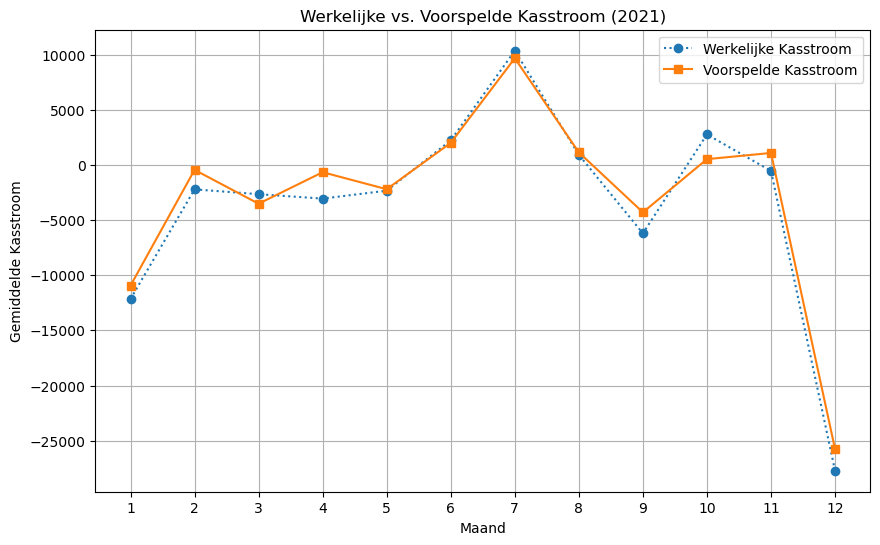

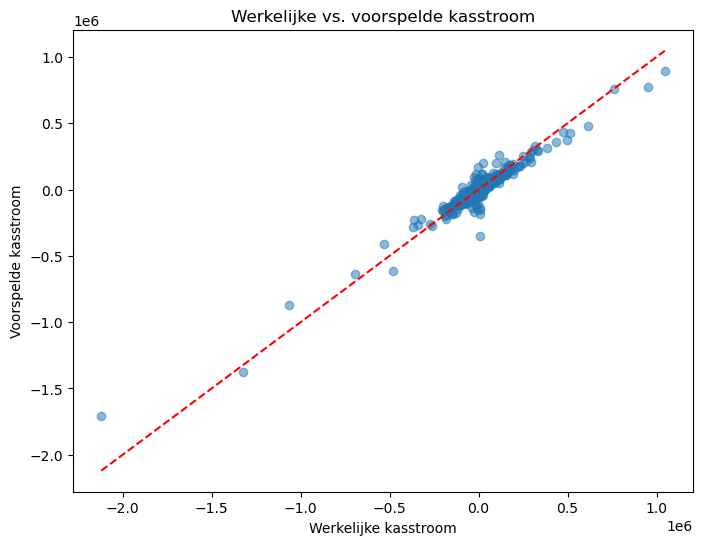

✅ Model opgeslagen als 'voorspelmodel_kasstroom.pkl' en features opgeslagen als 'model_features.pkl'!


In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

file_path = "cleaned_feature_data.csv"
df = pd.read_csv(file_path)

df['datum'] = pd.to_datetime(df['datum'])
df['jaar'] = df['datum'].dt.year
df['maand'] = df['datum'].dt.month
df = df.drop(columns=['datum'])

correlation_matrix = df.corr()
high_corr_pairs = []
threshold = 0.9

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            col1 = correlation_matrix.columns[i]
            col2 = correlation_matrix.columns[j]
            high_corr_pairs.append((col1, col2, correlation_matrix.iloc[i, j]))

high_corr_df = pd.DataFrame(high_corr_pairs, columns=['Feature 1', 'Feature 2', 'Correlatie'])
print("Sterk gecorreleerde features:\n", high_corr_df)

features_to_remove = [feature for feature in high_corr_df['Feature 1'].unique() if feature not in ['jaar', 'maand']]
df_cleaned = df.drop(columns=features_to_remove)

print("Nieuwe datasetgrootte:", df_cleaned.shape)
df_cleaned.to_csv("cleaned_feature_data2.csv", index=False)

target_column = "totale_kasstroom"

if target_column in df_cleaned.columns:
    X = df_cleaned.drop(columns=[target_column])
    y = df_cleaned[target_column]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    time_info_test = X_test[['jaar', 'maand']]

    model = LinearRegression()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    print(f"MAE: {mae}")
    print(f"RMSE: {rmse}")
    print(f"R²-score: {r2}")

    feature_importance = pd.DataFrame({'Feature': X.columns, 'Belang': model.coef_})
    feature_importance = feature_importance.sort_values(by='Belang', key=abs, ascending=False)

    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance['Feature'][:10], feature_importance['Belang'][:10])
    plt.xlabel("Coefficiëntwaarde")
    plt.ylabel("Feature")
    plt.title("Top 10 Belangrijkste Features volgens Lineair Regressiemodel")
    plt.gca().invert_yaxis()
    plt.show()

    print("Top 10 belangrijkste features:\n", feature_importance.head(10))

    df_2021 = pd.DataFrame({
        'jaar': time_info_test['jaar'].values,
        'maand': time_info_test['maand'].values,
        'werkelijk': y_test.values,
        'voorspeld': y_pred
    })

    df_2021 = df_2021[df_2021['jaar'] == 2021]
    df_2021_grouped = df_2021.groupby('maand').mean().reset_index()

    plt.figure(figsize=(10, 6))
    plt.plot(df_2021_grouped['maand'], df_2021_grouped['werkelijk'], marker='o', linestyle='dotted', label="Werkelijke Kasstroom")
    plt.plot(df_2021_grouped['maand'], df_2021_grouped['voorspeld'], marker='s', linestyle='solid', label="Voorspelde Kasstroom")
    plt.xlabel("Maand")
    plt.ylabel("Gemiddelde Kasstroom")
    plt.title("Werkelijke vs. Voorspelde Kasstroom (2021)")
    plt.xticks(range(1, 13))
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.xlabel("Werkelijke kasstroom")
    plt.ylabel("Voorspelde kasstroom")
    plt.title("Werkelijke vs. voorspelde kasstroom")
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='dashed')
    plt.show()

else:
    print("De target kolom is niet gevonden in de dataset!")

model_filename = "voorspelmodel_kasstroom.pkl"
joblib.dump(model, model_filename)

features_filename = "model_features.pkl"
joblib.dump(X.columns.tolist(), features_filename)

print(f"✅ Model opgeslagen als '{model_filename}' en features opgeslagen als '{features_filename}'!")


In [1]:
import pandas as pd

df = pd.read_csv("data_met_2_clusters.csv", parse_dates=["datum"])

def clean_column(col):
    return (
        col.lower()
           .replace("(", "")
           .replace(")", "")
           .replace(",", "_")
           .replace("%", "pct")
           .replace("/", "_")
           .replace(" ", "_")
           .replace("€", "eur")
           .replace("__", "_")
    )

original_columns = df.columns.tolist()
cleaned_columns = [clean_column(col) for col in original_columns]
col_mapping = dict(zip(original_columns, cleaned_columns))
df.columns = cleaned_columns

df.to_csv("data_cleaned.csv", index=False)
print("Cleande dataset opgeslagen als: data_cleaned.csv")

print("\nOriginele → Cleande kolomnamen:")
for orig, clean in col_mapping.items():
    if orig != clean:
        print(f"{orig} → {clean}")


✅ Cleande dataset opgeslagen als: data_cleaned.csv

📋 Originele → Cleande kolomnamen:
- %_insteek_van_de_melkkoeien  →  pct_insteek_van_de_melkkoeien
- %_sterfte_melkkoeien  →  pct_sterfte_melkkoeien
- %_uitstoot_van_de_melkkoeien  →  pct_uitstoot_van_de_melkkoeien
- %_uitval_levend_geboren_kalveren  →  pct_uitval_levend_geboren_kalveren
- dierenarts/gezondheidszorg  →  dierenarts_gezondheidszorg
- gas,_water_en_electra  →  gas_water_en_electra
- geteelde_gewassen_(grasland,_granen)  →  geteelde_gewassen_grasland_granen
- huren/pachten  →  huren_pachten
- ki/fokkerij  →  ki_fokkerij
- lonen,_salarissen_en_uitbesteed_werk  →  lonen_salarissen_en_uitbesteed_werk
- lonen,_salarissen,_sociale_lasten_en_uitbesteed_werk  →  lonen_salarissen_sociale_lasten_en_uitbesteed_werk
- loonbelasting/volksverzekeringen  →  loonbelasting_volksverzekeringen
- melkcontrole,_stamboek  →  melkcontrole_stamboek
- zaden,_plant-_en_pootgoed  →  zaden_plant-_en_pootgoed
- aangehouden_kalveren_als_%_van_aantal_m

In [2]:
import pandas as pd


df = pd.read_csv("cleaned_feature_data_met_melk_en_voerprijs.csv")


numeric_df = df.select_dtypes(include=['number'])


corr_matrix = numeric_df.corr().abs()


threshold = 0.9
high_corr_pairs = []

for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if corr_matrix.iloc[i, j] > threshold:
            high_corr_pairs.append((
                corr_matrix.columns[i],
                corr_matrix.columns[j],
                corr_matrix.iloc[i, j]
            ))


high_corr_df = pd.DataFrame(high_corr_pairs, columns=['Feature 1', 'Feature 2', 'Correlatie'])
high_corr_df = high_corr_df.sort_values(by='Correlatie', ascending=False)

print(high_corr_df)


                                         Feature 1  \
0                                   eu_toeslagen.1   
225                                           jaar   
12   kosten_machines_(en_installaties)_en_loonwerk   
11   kosten_machines_(en_installaties)_en_loonwerk   
197                                 omzet_melk_(€)   
..                                             ...   
186                                   omzet_melk.1   
226                               melkprijs_per_kg   
234                            melkprijs_per_100kg   
218                           voorschot_melkgeld.1   
164                melkkoeien_-_aantal_beginbalans   

                         Feature 2  Correlatie  
0                     eu_toeslagen    1.000000  
225                       boekjaar    1.000000  
12                        koesaldo    1.000000  
11                bedrijfsgegevens    1.000000  
197                omzet_en_aanwas    1.000000  
..                             ...         ...  
186    k

In [6]:
import pandas as pd


df = pd.read_csv("cleaned_feature_data_met_melk_en_voerprijs.csv")


target_column = "totale_kasstroom"


numeric_df = df.select_dtypes(include=["number"]).copy()


numeric_df = numeric_df[numeric_df[target_column].notna()]


corr_matrix = numeric_df.corr().abs()


target_corr = corr_matrix[target_column].drop(target_column)


threshold = 0.9
to_remove = set()


for i in range(len(corr_matrix.columns)):
    for j in range(i):
        col1 = corr_matrix.columns[i]
        col2 = corr_matrix.columns[j]

        if col1 == target_column or col2 == target_column:
            continue

        if corr_matrix.loc[col1, col2] > threshold:
            corr1 = abs(corr_matrix.loc[col1, target_column])
            corr2 = abs(corr_matrix.loc[col2, target_column])

            if corr1 >= corr2:
                to_remove.add(col2)
            else:
                to_remove.add(col1)


df_cleaned.to_csv("dataset_zonder_multicollineariteit.csv", index=False)

print(f"Aantal verwijderde features: {len(to_remove)}")
print(f"Aantal overgebleven features: {df_cleaned.shape[1]}")
print("Voorbeeld van verwijderde features:", list(to_remove)[:96])


Aantal verwijderde features: 97
Aantal overgebleven features: 234
Voorbeeld van verwijderde features: ['lonen,_salarissen_en_uitbesteed_werk', 'omzet_melk.1', 'kritieke_opbrengstprijs', 'jongvee_jonger_dan_1_jaar_-_aantal_beginbalans', 'koesaldo_per_melkkoe', 'jongvee_jonger_dan_1_jaar_-_aantal_eindbalans', 'leasekosten_productierechten', 'geteelde_gewassen_(grasland,_granen)', 'opbrengsten_van_financiële_vaste_activa', 'overige_opbrengsten_en_bijzondere_resultaten', 'per_melkkoe', 'ruwvoerkosten_rundvee', 'krachtvoerkosten.1', 'afgeleverde_kg_melk_per_koe', 'debiteuren', 'saldo_melkvee', 'leningen', 'kosten_machines_(en_installaties)_en_loonwerk', 'grond-_en_hulpstoffen', 'omzet_en_aanwas_per_100_kg_melk', 'melkprijs_per_100kg', 'melkprijs_per_kg', 'jaar', 'omzet_melk_(€)', 'totaal_kg_eiwit', 'jongvee_ouder_dan_1_jaar_(€)', 'veekosten.1', 'veekosten', 'veebezettting', 'per_100kg_melk', 'rentebaten_en_soortgelijke_opbrengsten', 'materiële_vaste_activa', 'voorschot_melkgeld.1', 'totaal_

In [8]:
import pandas as pd


df = pd.read_csv("cleaned_feature_data_met_melk_en_voerprijs.csv") 

#de lijst van hierboven eruit gehaald, behalve voer en melkprijs. 
features_to_maybe_remove = [
    'lonen,_salarissen_en_uitbesteed_werk', 'omzet_melk.1', 'kritieke_opbrengstprijs',
    'jongvee_jonger_dan_1_jaar_-_aantal_beginbalans', 'koesaldo_per_melkkoe',
    'jongvee_jonger_dan_1_jaar_-_aantal_eindbalans', 'leasekosten_productierechten',
    'geteelde_gewassen_(grasland,_granen)', 'opbrengsten_van_financiële_vaste_activa',
    'overige_opbrengsten_en_bijzondere_resultaten', 'per_melkkoe', 'ruwvoerkosten_rundvee',
    'krachtvoerkosten.1', 'afgeleverde_kg_melk_per_koe', 'saldo_melkvee',
    'leningen', 'kosten_machines_(en_installaties)_en_loonwerk', 'grond-_en_hulpstoffen',
    'omzet_en_aanwas_per_100_kg_melk', 'melkprijs_per_100kg', 
    'omzet_melk_(€)', 'totaal_kg_eiwit', 'jongvee_ouder_dan_1_jaar_(€)', 'veekosten.1',
    'veekosten', 'veebezettting', 'per_100kg_melk', 'rentebaten_en_soortgelijke_opbrengsten',
    'materiële_vaste_activa', 'voorschot_melkgeld.1', 'totaal_bedrijfskosten', 'eu_toeslagen',
    'handelsdebiteuren', 'teeltkosten_grasland_en_voedergewassen', 'beginsaldo_liquide_middelen',
    'onttrekkingen_privé_(genormaliseerd)', 'directe_kosten_(subtotaal_rs)',
    'jongvee_ouder_dan_1_jaar_-_aantal_eindbalans', 'ha_grasland',
    'fokstieren_-_aantal_eindbalans', 'kg_vet_en_eiwit_per_kg_fosfaat', 'voerkosten_rundvee',
    'werkelijke_opbrengstprijs', 'melkkoeien_-_aantal_eindbalans',
    'prive-belastingen_en_toeslagen_huidig_jaar', 'mutatie_overige_vorderingen',
    'veekosten_per_100_kg_melk', 'bedrijfsgegevens', 'resultaat_vóór_kapitaallasten',
    'huren_en_pachten', 'mestkosten_per_melkkoe', 'omzet_en_aanwas', 'ha_voedergewassen',
    'overige_bedrijfskosten', 'mengvoer_(incl_droge_bijproducten)', 'huren/pachten',
    'ha_grasland_en_voedergewassen', 'krachtvoerkosten_per_100_kg_melk',
    'immateriële_vaste_activa', 'ruwvoerkosten_per_100_kg_melk', 'melkopbrengsten',
    'personeelskosten_(€)', 'geboren_kalveren_(incldoodgeboren)', 'personeelkosten',
    'productietechnisch_melkveehouderij', 'afschrijving_vaste_activa', 'energiekosten.1',
    'aantallen_begin-_en_eindbalans', 'omzet_melk', 'heffingen_en_premies.1', 'vetgehalte',
    'fosfaatrechten_(kg_benutbaar_in_jaar)', 'jongvee_jonger_dan_1_jaar_(€)',
    'krachtvoerkosten.2', 'totaal_kg_mengvoer', 'koesaldo',
    'belastingen_en_toeslagen_huidig_jaar', 'melkkoeien_-_aantal_beginbalans',
    'mestkosten', 'melkopbrengst_per_100_kg_melk', 'ruwvoerkosten',
    'kosten_machines_(en_installaties)_en_loonwerk_per_100_kg_melk',
    'investering_machines_en_installaties', 'overige_schulden', 'afschrijving_gebouwen',
    'saldo_neventak', 'lonen,_salarissen,_sociale_lasten_en_uitbesteed_werk',
    'werkelijke_aflossingen', 'kosten_machines_(en_installaties)_per_ha',
    'koesaldo_per_100kg_melk', 'resultaat','totale_kasstroom_lag1',
    'totale_kasstroom_lag3',
    'totale_kasstroom_lag6',
    'totale_kasstroom_lag12',
    'totale_kasstroom_rolling3',
    'totale_kasstroom_rolling6',
    'totale_kasstroom_rolling12',

]


df_cleaned = df.drop(columns=[col for col in features_to_maybe_remove if col in df.columns])


df_cleaned.to_csv("data_no_multicorr.csv", index=False)




In [21]:
import pandas as pd

# 1. Dataset inladen
df = pd.read_csv("data_no_multicorr.csv")

# 2. Zorg dat datum een datetime is en sorteer correct
df["datum"] = pd.to_datetime(df["datum"])
df = df.sort_values(["volgnr", "datum"]).reset_index(drop=True)

# 3. Lagged & rolling features per boer toevoegen
def add_lagged_features(group):
    group = group.copy()
    group = group.sort_values("datum")
    
    # Lagged
    group["kasstroom_lag1"] = group["totale_kasstroom"].shift(1)
    group["kasstroom_lag3"] = group["totale_kasstroom"].shift(3)
    
    # Rolling met shift om leakage te voorkomen
    group["kasstroom_rolling3"] = group["totale_kasstroom"].shift(1).rolling(3).mean()
    group["kasstroom_rolling6"] = group["totale_kasstroom"].shift(1).rolling(6).mean()
    
    return group

# 4. Toepassen per boer
df_with_lags = df.groupby("volgnr").apply(add_lagged_features).reset_index(drop=True)

# 5. Opslaan als nieuwe CSV
df_with_lags.to_csv("data_met_lagged_features.csv", index=False)
print("✅ Bestand opgeslagen als: data_met_lagged_features.csv")


✅ Bestand opgeslagen als: data_met_lagged_features.csv


In [2]:
conda update jupyter notebook

Channels:
 - defaults
Platform: linux-64
Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/anaconda-2024.02-py310

  added / updated specs:
    - jupyter
    - notebook


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2025.1.31          |  py310h06a4308_0         162 KB
    jupyter-1.1.1              |  py310h06a4308_0           8 KB
    notebook-7.0.8             |  py310h06a4308_2         3.3 MB
    openssl-3.0.16             |       h5eee18b_0         5.2 MB
    ------------------------------------------------------------
                                           Total:         8.7 MB

The following packages will be UPDATED:

  ca-certificates                      2024.3.11-h06a4308_0 --> 2025.2.25-h06a4308_0 
  certifi                          2024.2.2-py310h06a4308_0 --> 2025.1.31-py310h06a4308_0 
  jupyter                             1

<Axes: >

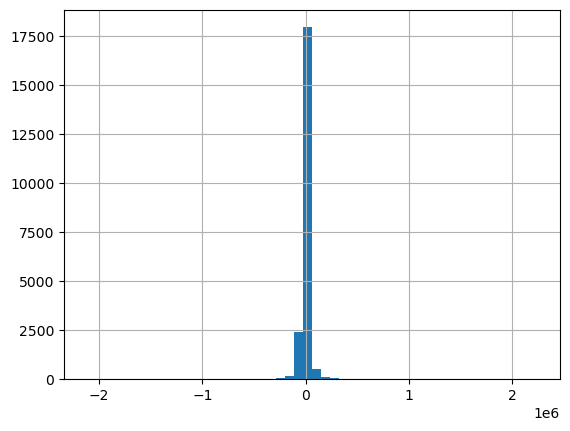

In [12]:
import matplotlib.pyplot as plt
df["totale_kasstroom"].hist(bins=50)



In [40]:
import pandas as pd

# Laad de dataset
df = pd.read_csv("data_met_lagged_features.csv")

# Zorg dat de datumkolom goed is geparsed
df['datum'] = pd.to_datetime(df['datum'])
df['jaar_maand'] = df['datum'].dt.to_period('M')  # Voor maandgroepering

# Stel onder- en bovengrens in voor realistische prijzen
min_prijs = 0       # geen negatieve prijzen
max_prijs = 5       # maximale realistische melk-/voerprijs in €/kg

# Detecteer outliers: alles buiten het bereik [0, 5]
melkprijs_outliers = (df['melkprijs_per_kg'] < min_prijs) | (df['melkprijs_per_kg'] > max_prijs)
voerprijs_outliers = (df['voerprijs'] < min_prijs) | (df['voerprijs'] > max_prijs)

# Bereken maandgemiddelden op basis van geldige (niet-outlier) waarden
melkprijs_gemiddelden = df.loc[~melkprijs_outliers].groupby('jaar_maand')['melkprijs_per_kg'].mean()
voerprijs_gemiddelden = df.loc[~voerprijs_outliers].groupby('jaar_maand')['voerprijs'].mean()

# Vul outliers in met het maandgemiddelde
df.loc[melkprijs_outliers, 'melkprijs_per_kg'] = df.loc[melkprijs_outliers, 'jaar_maand'].map(melkprijs_gemiddelden)
df.loc[voerprijs_outliers, 'voerprijs'] = df.loc[voerprijs_outliers, 'jaar_maand'].map(voerprijs_gemiddelden)

# Verwijder de tijdelijke kolom
df.drop(columns='jaar_maand', inplace=True)

# Sla het resultaat op als nieuwe CSV
df.to_csv("data_corrected_melk_voerprijzen.csv", index=False)

In [41]:
def remove_outliers_iqr(group, col="totale_kasstroom"):
    Q1 = group[col].quantile(0.25)
    Q3 = group[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return group[(group[col] >= lower) & (group[col] <= upper)]

# Pas toe per boer
df_no_outliers = df.groupby("volgnr").apply(remove_outliers_iqr).reset_index(drop=True)
df_no_outliers.shape
df_no_outliers.to_csv("data_no_outliers.csv", index=False)

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Laad opgeschoonde data
df = pd.read_csv("data_corrected_melk_voerprijzen.csv")

# Agregeer per boerderij
df_agg = df.groupby('volgnr').agg({
    'melkprijs_per_kg': 'mean',
    'voerprijs': 'mean',
    'aankopen_rundvee': 'sum',
    'aanwas_rundvee': 'sum',
    'totale_kasstroom': ['mean', 'std']
}).dropna()

# Kolomnamen aanpassen
df_agg.columns = ['_'.join(col) for col in df_agg.columns]

# Normaliseer en cluster
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_agg)
kmeans = KMeans(n_clusters=3, random_state=42)
df_agg['cluster'] = kmeans.fit_predict(X_scaled)

# Bewaar alleen volgnr + cluster
df_agg[['cluster']].to_csv("data_with_clusters.csv")
print("✅ Clusters opgeslagen als 'bedrijfsclusters.csv'")


cluster
 5    16228
-1     3874
 6      891
 2      156
 4       54
 3       45
 0       39
 1       37
Name: count, dtype: int64


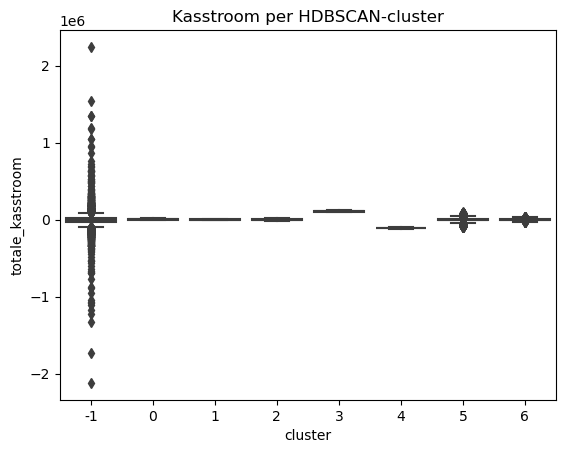

In [12]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import hdbscan
import matplotlib.pyplot as plt
import seaborn as sns

# Laad je dataset
df = pd.read_csv("data_corrected_melk_voerprijzen.csv")

# Selecteer relevante en beschikbare features
features = ['melkprijs_per_kg', 'voerprijs', 'aankopen_rundvee', 'aanwas_rundvee', 'totale_kasstroom']
df_cluster = df[features].dropna()

# Normaliseren
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster)

# HDBSCAN clustering
clusterer = hdbscan.HDBSCAN(min_cluster_size=30, min_samples=5)
df_cluster['cluster'] = clusterer.fit_predict(X_scaled)

# Voeg toe aan originele dataset (optioneel)
df['cluster_hdbscan'] = pd.NA
df.loc[df_cluster.index, 'cluster_hdbscan'] = df_cluster['cluster'].values

# Bekijk de clusterverdeling
print(df_cluster['cluster'].value_counts(dropna=False))

# Visualisatie (optioneel)
sns.boxplot(data=df_cluster, x='cluster', y='totale_kasstroom')
plt.title("Kasstroom per HDBSCAN-cluster")
plt.show()



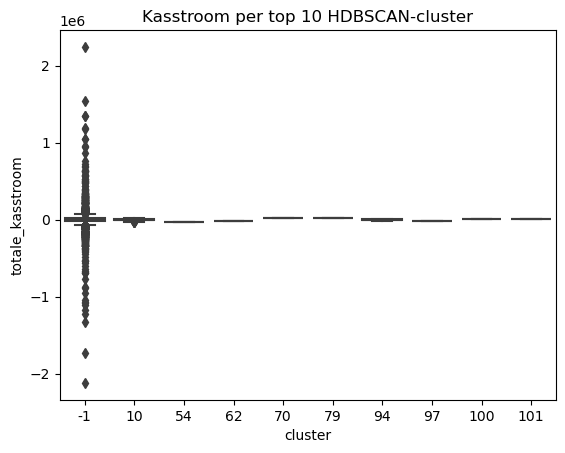

In [2]:

top_clusters = df_cluster['cluster'].value_counts().head(10).index
df_top = df_cluster[df_cluster['cluster'].isin(top_clusters)]

sns.boxplot(data=df_top, x='cluster', y='totale_kasstroom')
plt.title("Kasstroom per top 10 HDBSCAN-cluster")
plt.show()


/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


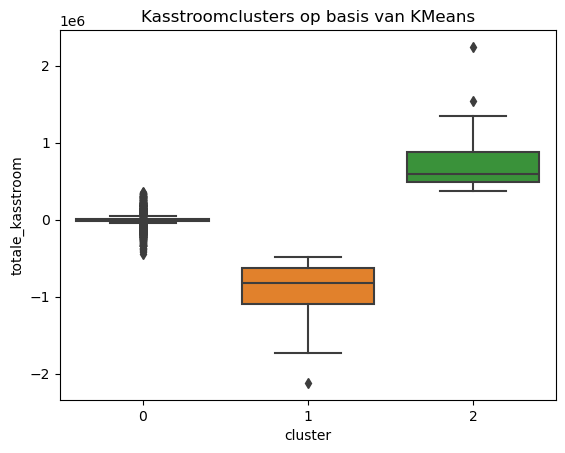

cluster
0       117.256021
1   -915850.041667
2    732638.500000
Name: totale_kasstroom, dtype: float64


In [25]:
# --- Clustering op basis van kasstroom per maand (individuele records) ---

import pandas as pd
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt

# Laad dataset
df = pd.read_csv("data_corrected_melk_voerprijzen.csv")

# Kies alleen rijen met kasstroomdata
df_kasstroom = df[['totale_kasstroom']].dropna()

# Vorm geschikt voor clustering
X_kasstroom = df_kasstroom.values.reshape(-1, 1)

# Pas KMeans toe (3 clusters)
kmeans_kas = KMeans(n_clusters=3, random_state=42)
df_kasstroom['cluster'] = kmeans_kas.fit_predict(X_kasstroom)

# Visualiseer clusters
sns.boxplot(data=df_kasstroom, x='cluster', y='totale_kasstroom')
plt.title('Kasstroomclusters op basis van KMeans')
plt.show()

# Toon gemiddelde kasstroom per cluster
print(df_kasstroom.groupby('cluster')['totale_kasstroom'].mean())


In [39]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# 📥 1. Laad dataset
df = pd.read_csv("data_corrected_melk_voerprijzen.csv", parse_dates=["datum"])
df['datum'] = pd.to_datetime(df['datum'])  # Zorg dat de datums goed zijn

# 📌 2. Clustering op bedrijfskenmerken per boer
df_agg = df.groupby('volgnr').agg({
    'melkprijs_per_kg': 'mean',
    'voerprijs': 'mean',
    'aankopen_rundvee': 'sum',
    'aanwas_rundvee': 'sum',
    'totale_kasstroom': ['mean', 'std']
}).dropna()

df_agg.columns = ['_'.join(col) for col in df_agg.columns]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_agg)

kmeans_bedrijf = KMeans(n_clusters=3, random_state=42)
df_agg['bedrijf_cluster'] = kmeans_bedrijf.fit_predict(X_scaled)

df = df.merge(df_agg[['bedrijf_cluster']], left_on='volgnr', right_index=True, how='left')

# 💾 4. Sla het eindresultaat op
df.to_csv("data_with_clusters.csv", index=False)
print("✅ 'data_with_clusters.csv' succesvol opgeslagen.")


/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


✅ 'data_with_clusters.csv' succesvol opgeslagen.


In [1]:
import pandas as pd

# 📥 1. Laad de dataset
df = pd.read_csv("data_with_clusters.csv")
df["datum"] = pd.to_datetime(df["datum"])
df = df.sort_values(["volgnr", "datum"]).reset_index(drop=True)

# 🧼 2. Drop bestaande lagged & rolling kolommen als die al bestaan
cols_to_drop = [
    "kasstroom_lag1", "kasstroom_lag3",
    "kasstroom_rolling3", "kasstroom_rolling6"
]
df = df.drop(columns=[col for col in cols_to_drop if col in df.columns], errors="ignore")

# Opslaan als tussentijdse versie (optioneel)
df.to_csv("data_without_old_lags.csv", index=False)


In [2]:
# 📥 1. Laad dataset zonder oude lags
df = pd.read_csv("data_without_old_lags.csv")
df["datum"] = pd.to_datetime(df["datum"])
df = df.sort_values(["volgnr", "datum"]).reset_index(drop=True)

# 🧠 2. Definieer variabelen en bijbehorende lags (Granger-based)
granger_lags = {
    "totale_kasstroom": [1, 3],
    "melkprijs_per_kg": [1, 3, 6],
    "totaal_opbrengsten": [1, 3, 6],
    "krachtvoerkosten": [1, 3, 6],
    "voerkosten": [4, 5, 6],
    "gemiddelde_temperatuur": [5, 6],
}

# 🧠 3. Functie om lags toe te voegen zonder leakage
def add_granger_lags(group):
    group = group.sort_values("datum").copy()
    
    for var, lags in granger_lags.items():
        if var in group.columns:
            for lag in lags:
                colname = f"{var}_lag_{lag}"
                group[colname] = group[var].shift(lag)
    
    return group

# 🚀 4. Pas toe per boer
df_lagged = df.groupby("volgnr").apply(add_granger_lags).reset_index(drop=True)

# 💾 5. Opslaan
df_lagged.to_csv("data_met_granger_lags.csv", index=False)
print("✅ Nieuwe lagged features toegevoegd en opgeslagen als: data_met_granger_lags.csv")


✅ Nieuwe lagged features toegevoegd en opgeslagen als: data_met_granger_lags.csv


In [3]:
import pandas as pd
from scipy.stats.mstats import winsorize

# 📥 Laad de dataset
df = pd.read_csv("data_met_granger_lags.csv", parse_dates=["datum"])
df = df.sort_values(["volgnr", "datum"]).reset_index(drop=True)

# 🎯 Kies financiële kolommen waarvan je weet dat ze veel outliers bevatten
financial_cols = [
    "kas",
    "crediteuren",
    "eindsaldo_liquide_middelen",
    "mutaties_vorderingen_en_schulden",
    "resultaat_vóór_bijzondere_resultaten"
]

# 🧼 Winsorisatie-functie per boer (volgnr)
def winsorize_group(group, columns, limits=(0.01, 0.01)):
    group = group.copy()
    for col in columns:
        if col in group.columns:
            # Zorg ervoor dat de kolom geen NaNs bevat
            valid = group[col].dropna()
            if len(valid) >= 10:  # alleen toepassen als er genoeg data is
                winsorized = winsorize(valid, limits=limits)
                group.loc[valid.index, col] = winsorized
    return group

# 📦 Pas toe op elke boer afzonderlijk
df_winsorized = df.groupby("volgnr").apply(lambda g: winsorize_group(g, financial_cols)).reset_index(drop=True)

# 💾 Opslaan voor LSTM/GRU pipeline
df_winsorized.to_csv("data_winsorized_financials.csv", index=False)
print("✅ Winsorized dataset opgeslagen als: data_winsorized_financials.csv")


✅ Winsorized dataset opgeslagen als: data_winsorized_financials.csv


/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na opti

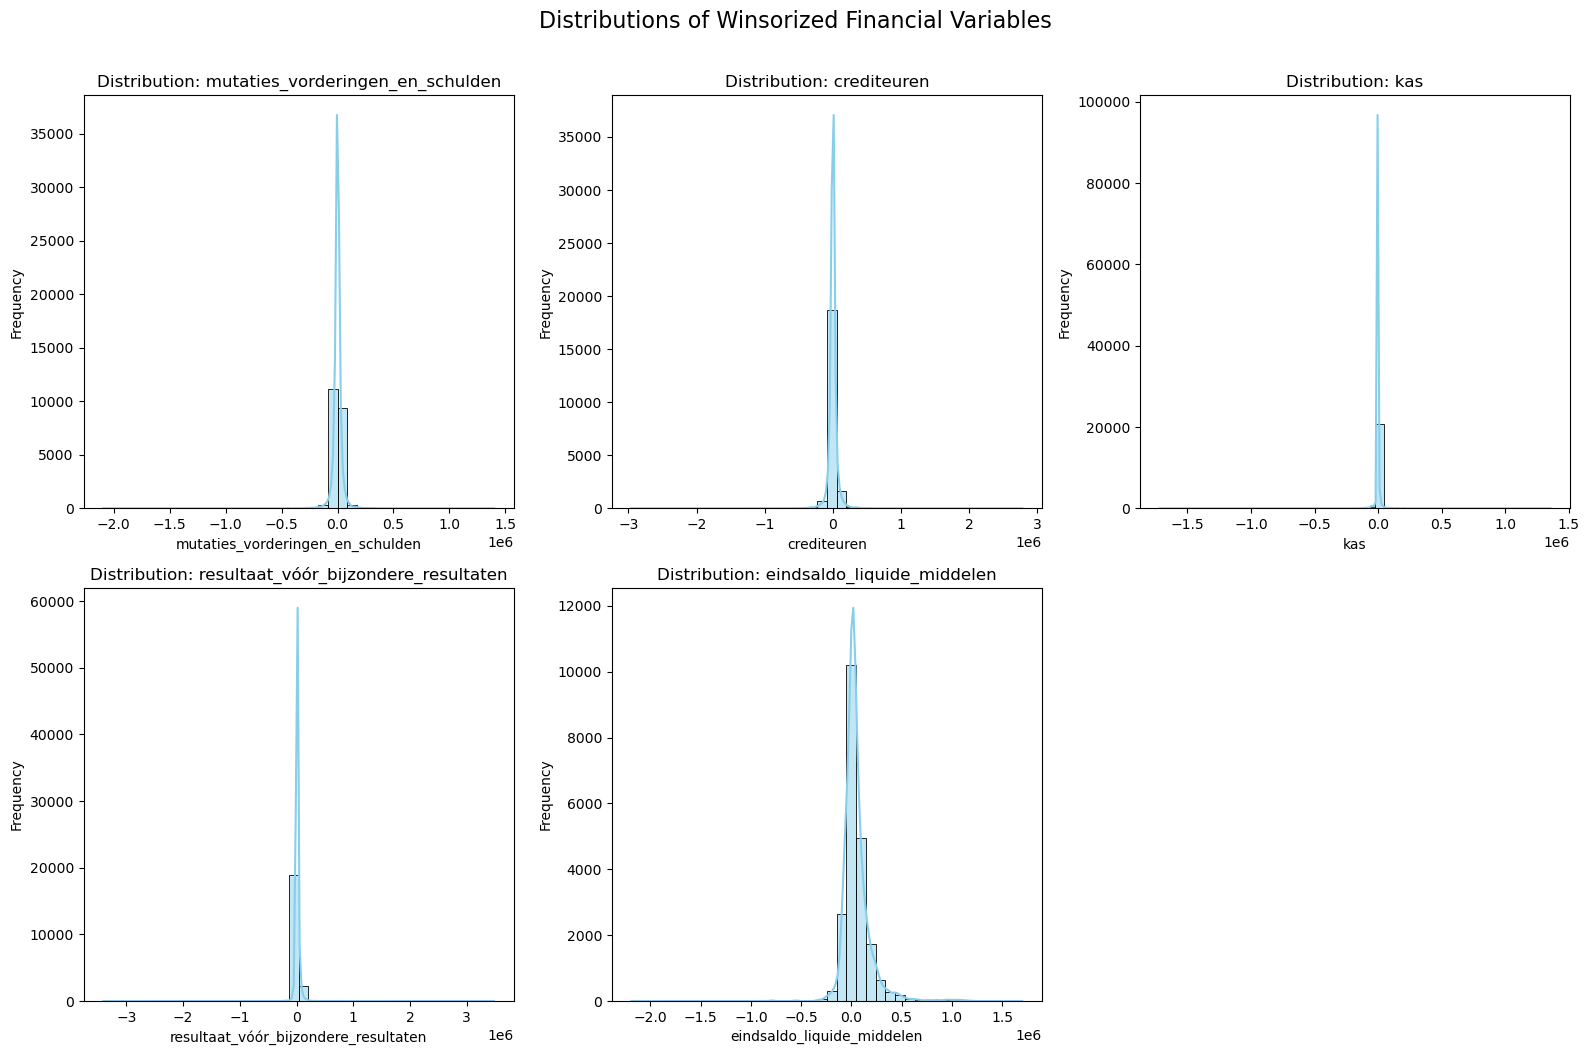

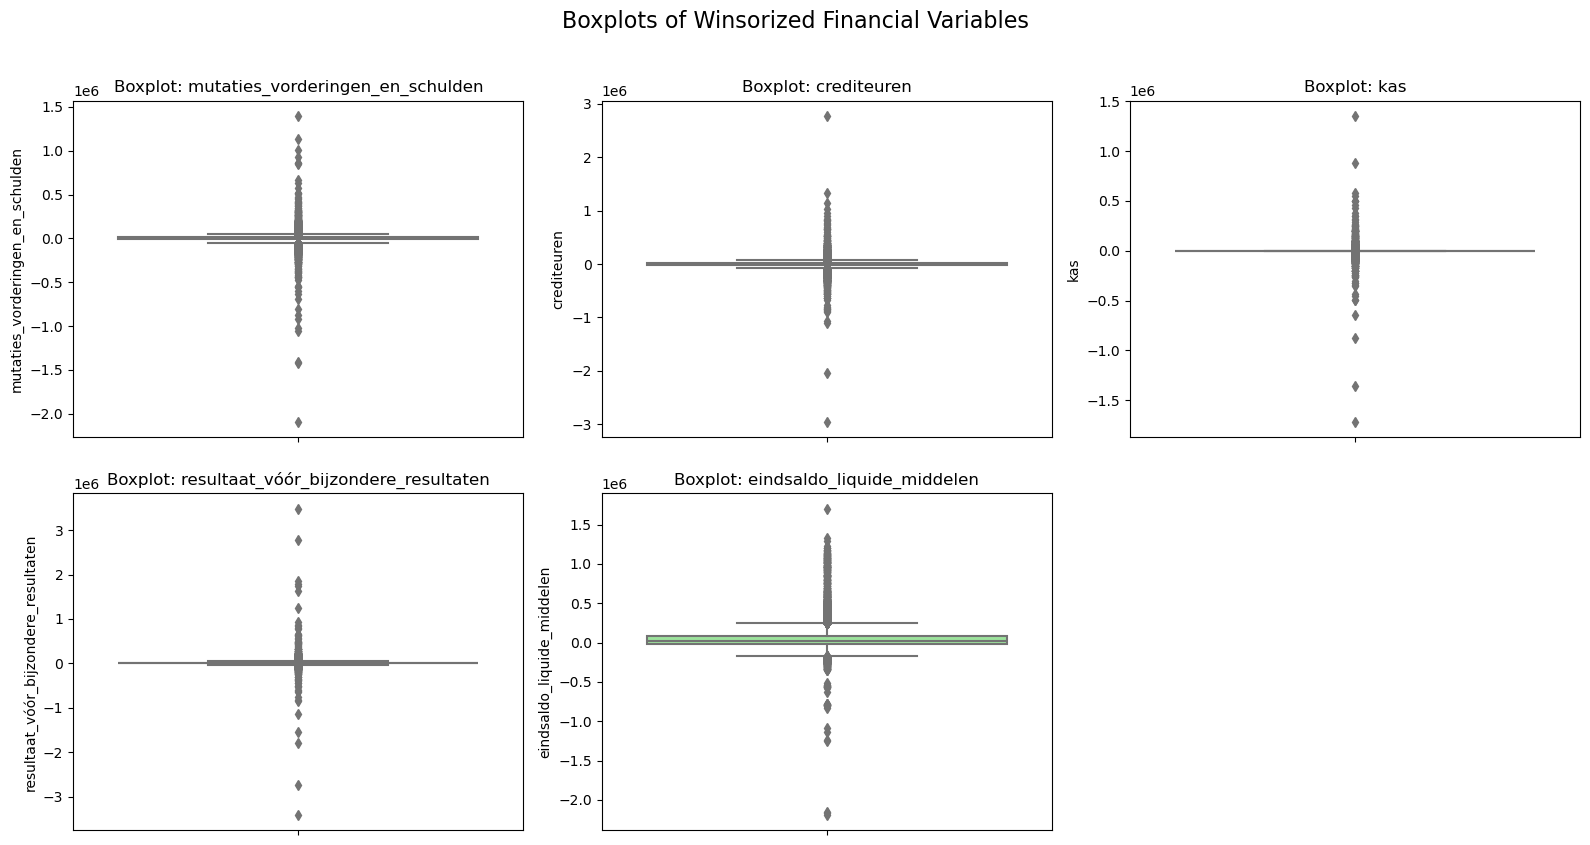

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 📥 1. Laad de winsorized dataset
df = pd.read_csv("data_winsorized_financials.csv")

# 🧾 2. Selecteer de belangrijkste financiële variabelen
financial_vars = [
    "mutaties_vorderingen_en_schulden",
    "crediteuren",
    "kas",
    "resultaat_vóór_bijzondere_resultaten",
    "eindsaldo_liquide_middelen"
]

# 📈 3. Distributieplots maken (histogram + KDE)
plt.figure(figsize=(16, 10))
for i, col in enumerate(financial_vars):
    plt.subplot(2, 3, i + 1)
    sns.histplot(df[col], kde=True, bins=40, color='skyblue')
    plt.title(f"Distribution: {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
plt.tight_layout()
plt.suptitle("Distributions of Winsorized Financial Variables", fontsize=16, y=1.05)
plt.show()

# 📦 4. Boxplots om outliers visueel te checken
plt.figure(figsize=(16, 8))
for i, col in enumerate(financial_vars):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(y=df[col], color='lightgreen')
    plt.title(f"Boxplot: {col}")
plt.tight_layout()
plt.suptitle("Boxplots of Winsorized Financial Variables", fontsize=16, y=1.05)
plt.show()


In [6]:
import pandas as pd

# Laad dataset
df = pd.read_csv("data_winsorized_financials.csv")

# Kolommen waarin negatieve waarden foutief zijn
cols_to_fix = ["voerkosten", "krachtvoerkosten", "totaal_opbrengsten"]

# Corrigeer de tekens
for col in cols_to_fix:
    df[col] = df[col].abs()

# Opslaan
df.to_csv("data_final.csv", index=False)


In [5]:
import pandas as pd

# Load your dataset
df = pd.read_csv("data_final.csv")

# Ensure date column is parsed
df['datum'] = pd.to_datetime(df['datum'], errors='coerce')

# Identify invalid entries (zero cows)
invalid_mask = df['aantal_melkkoeien'] == 0

# Step 1: Compute the average number of cows per farm (excluding zeros)
bedrijfsgemiddelde = df.loc[~invalid_mask].groupby('volgnr')['aantal_melkkoeien'].mean()

# Step 2: Create new column to track imputations
df['koeien_geimputeerd'] = False

# Step 3: Impute zero values with the farm average
impute_mask = invalid_mask & df['volgnr'].isin(bedrijfsgemiddelde.index)
df.loc[impute_mask, 'aantal_melkkoeien'] = df.loc[impute_mask, 'volgnr'].map(bedrijfsgemiddelde)
df.loc[impute_mask, 'koeien_geimputeerd'] = True

# Step 4: Impute remaining (NaNs) with global fallback mean of farm averages
df['aantal_melkkoeien'] = df['aantal_melkkoeien'].fillna(bedrijfsgemiddelde.mean())
df.loc[df['aantal_melkkoeien'] == bedrijfsgemiddelde.mean(), 'koeien_geimputeerd'] = True

# Save the cleaned dataset
df.to_csv("data_final.csv", index=False)

# Report how many values were imputed
print("Total values imputed:", df['koeien_geimputeerd'].sum())


Total values imputed: 4332
